# IMPORT part

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import argparse
import imutils
import time
import dlib
import cv2
from google.colab.patches import cv2_imshow
import os
import math
import csv
from pathlib import Path
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch import flatten
import torch.nn as nn
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, LogSoftmax, Dropout
import torchvision.transforms.functional as TF
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
import torch.utils.data as data_utils
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torchvision import transforms
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

import sys
sys.path.append('/content/drive/MyDrive/NAPOLI/code/mtcnn/')
from mtcnn import MTCNN

# **Preparation of the dataset for HEGClass**

## **Head ad Gaze pose estimation**

## ****FUNCTIONS INTERNAL PART****

In [6]:
class PoseEstimator:
    def __init__(self, weights=None):
      self.detector =  MTCNN()

    def detect_faces(self, image, image_shape_max=640):
      '''
      Parameters
      ----------
      image : uint8 image for face detection.
      image_shape_max : int, optional maximum size (in pixels) of image. The default is None.

      Returns
      -------
      float array bounding boxes and score.
      float array landmarks.

      '''
      image_shape = image.shape[:2]

      # perform image resize for faster detection
      if image_shape_max:
          scale_factor = max([1, max(image_shape) / image_shape_max])
      else:
          scale_factor = 1

      if scale_factor > 1:
          scaled_image = cv2.resize(image, (0, 0), fx = 1/scale_factor, fy = 1/scale_factor)

          start = time.time()
          print("[INFO[ performing face detection with MTCNN...")
          boxes, points = self.detector.detect_faces(scaled_image)
          end = time.time()
          print("[INFO] face detection took {:.4f} seconds".format(end - start))

          boxes[:,:4] *= scale_factor
          points *= scale_factor

      else:
          start = time.time()
          print("[INFO[ performing face detection with MTCNN...")
          boxes, points = self.detector.detect_faces(image)
          end = time.time()
          print("[INFO] face detection took {:.4f} seconds".format(end - start))

      return boxes, points

    def draw_landmarks(self, image, boxes, points):
      '''
      Parameters
      ----------
      frame : TYPE RGB image
      bb : TYPE - Array of float64, Size = (5,) coordinates of bounding box for the selected face.
      points : TYPE - Array of float32, Size = (10,) coordinates of landmarks for the selected faces.

      Returns
      -------
      None.

      '''
      font = cv2.FONT_HERSHEY_COMPLEX # Text in video
      font_size = 0.6
      blue = (0, 0, 255)
      green = (0,128,0)
      red = (255, 0, 0)

      boxes = boxes.astype(int)
      points = points.astype(int)
      # draw rectangle and landmarks on face
      cv2.rectangle(image, (boxes[0], boxes[1]), (boxes[2], boxes[3]), red, 1)
      cv2.circle(image, (int(points[0]), int(points[5])), 2, blue, 2)# left eye
      cv2.circle(image, (int(points[1]), int(points[6])), 2, blue, 2)# right eye
      cv2.circle(image, (int(points[2]), int(points[7])), 2, blue, 2)# nose
      cv2.circle(image, (int(points[3]), int(points[8])), 2, blue, 2)# mouth - left
      cv2.circle(image, (int(points[4]), int(points[9])), 2, blue, 2)# mouth - right

      cv2_imshow(image)

      #w = int(boxes[2])-int(boxes[0]) # width
      #h = int(boxes[3])-int(boxes[1]) # height


    def one_face(self, frame, bbs, pointss):
      """
      Parameters
      ----------
      frame : TYPE RGB image (numpy array).
      bbs : TYPE - Array of flaot64, Size = (N, 5) coordinates of bounding boxes for all detected faces.
      pointss : TYPE - Array of flaot32, Size = (N, 10) coordinates of landmarks for all detected faces.
      Returns
      -------
      bb : TYPE - Array of float 64, Size = (5,) coordinates of bounding box for the selected face.
      points : TYPE coordinates of five landmarks for the selected face.
      """
      # select only process only one face (center)
      offsets = [(bbs[:,0]+bbs[:,2])/2-frame.shape[1]/2,
                (bbs[:,1]+bbs[:,3])/2-frame.shape[0]/2]
      offset_dist = np.sum(np.abs(offsets),0)
      index = np.argmin(offset_dist)
      bb = bbs[index]
      points = pointss[:,index]
      return bb, points


    def find_roll(self, points):
      """
      Parameters
      ----------
      points : TYPE - Array of float32, Size = (10,) coordinates of landmarks for the selected faces.
      Returns
      -------
      roll of face.

      """
      return points[6] - points[5]

    def find_yaw(self, points):
      """
      Parameters
      ----------
      points : TYPE - Array of float32, Size = (10,) coordinates of landmarks for the selected faces.
      Returns
      -------
      yaw of face.

      """
      le2n = points[2] - points[0]
      re2n = points[1] - points[2]
      return le2n - re2n

    def find_pitch(self, points):
      """
      Parameters
      ----------
      points : TYPE - Array of float32, Size = (10,) coordinates of landmarks for the selected faces.
      Returns
      -------
      Pitch
      """
      eye_y = (points[5] + points[6]) / 2
      mou_y = (points[8] + points[9]) / 2
      e2n = eye_y - points[7]
      n2m = points[7] - mou_y
      return e2n / n2m


In [7]:
class dataset(Dataset):

  def __init__(self, csv_file):
    self.sample_elements = []
    # sample_elements = [(sample_1), (sample_2),..]
    self.roll_pitch_yaw = []
    self.pupil_coords = []
    self.paths = []
    self.labels = []
    #self.faces_cropped = []
    self.names = []
    self.csv_file = csv_file
    self.extract_path_label_from_csv()


  def extract_path_label_from_csv(self):
    #read CSV
    with open(self.csv_file, mode ='r') as file:

      csvFile = csv.reader(file)

      for lines in csvFile:
        id_class = lines[1]
        name = lines[0]
        self.paths.append("/content/drive/MyDrive/NAPOLI/DATASET_FACE/PNG/HEAD-GAZE_DATASET/"+name[:3]+"/"+name+".png")
        self.labels.append(id_class)
        self.names.append(name)

    #print(self.paths)
    #print(self.labels)

    return

  def extract_eyestensor_headpose(self):

    """
    Parameters
    ----------
    path : path of an image
    dest_img_path : destination path of the image (after cropping)

    Returns
    -------
    face_crop : cropped image (with only the face)
    features : [roll, pitch, yaw, lx, ly, rx, ry] head pose angles + coordinates of the two pupils
    """
    #inizialize the pose estimator
    est = PoseEstimator()

    for i in self.paths:
      print(i)
      rpy = []
      pupils = []
      image = cv2.imread(i)

      image = imutils.resize(image, width=600)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# convert to rgb
      image_rgb = cv2.flip(image_rgb, 1)# flip for user friendliness

      bounding_boxes, landmarks = est.detect_faces(image_rgb)

      #print(bounding_boxes)

      if len(bounding_boxes) > 0:
        if len(bounding_boxes) >= 2:
          bounding_boxes, landmarks = est.one_face(image_rgb, bounding_boxes, landmarks)
          roll = est.find_roll(landmarks)
          pitch = est.find_pitch(landmarks)
          yaw = est.find_yaw(landmarks)

          lx = landmarks[0]
          ly = landmarks[5]
          rx = landmarks[1]
          ry = landmarks[6]

          '''
          bounding_boxes = bounding_boxes.astype(int)
          # draw rectangle on face
          x1 = bounding_boxes[0]
          y1 = bounding_boxes[1]
          x2 = bounding_boxes[2]
          y2 = bounding_boxes[3]
          img = cv2.flip(image, 1)
          #cv2.rectangle(img, (bounding_boxes[0], bounding_boxes[1]), (bounding_boxes[2], bounding_boxes[3]), red, 1)
          #cv2_imshow(img)

          w = bounding_boxes[2] - bounding_boxes[0]
          h = bounding_boxes[3] - bounding_boxes[1]
          max_s = max(w, h)

          diff_x = (max_s - w)/2
          diff_y = (max_s - h)/2

          #to cut the original immages, using face's box
          face_crop = img[int(y1-diff_y):int(y2+diff_y), int(x1-diff_x):int(x2+diff_x)]

          #cv2_imshow(face_crop)

          dest_img_path = .....
          cv2.imwrite(dest_img_path, face_crop)
          '''

        else:
          roll = est.find_roll(landmarks)
          pitch = est.find_pitch(landmarks)
          yaw = est.find_yaw(landmarks)
          lx = landmarks[0]
          ly = landmarks[5]
          rx = landmarks[1]
          ry = landmarks[6]

          '''
          bounding_boxes = bounding_boxes.astype(int)
          # draw rectangle on face
          x1 = bounding_boxes[0][0]
          y1 = bounding_boxes[0][1]
          x2 = bounding_boxes[0][2]
          y2 = bounding_boxes[0][3]
          img = cv2.flip(image, 1)
          #cv2.rectangle(img, (bounding_boxes[0][0], bounding_boxes[0][1]), (bounding_boxes[0][2], bounding_boxes[0][3]), red, 1)
          #cv2_imshow(img)

          w = bounding_boxes[0][2] - bounding_boxes[0][0]
          h = bounding_boxes[0][3] - bounding_boxes[0][1]
          max_s = max(w, h)

          diff_x = (max_s - w)/2
          diff_y = (max_s - h)/2

          #to cut the original immages, using face's box
          face_crop = img[int(y1-diff_y):int(y2+diff_y), int(x1-diff_x):int(x2+diff_x)]

          #cv2_imshow(face_crop)

          dest_img_path = .....
          cv2.imwrite(dest_img_path, face_crop)
          '''

      else:
        print("NO FACE FOUND")
        roll = 0.0
        pitch = 0.0
        yaw = 0.0
        lx = 0.0
        ly = 0.0
        rx = 0.0
        ry = 0.0

      rpy = [roll, pitch, yaw]
      pupils = [lx, ly, rx, ry]

      self.roll_pitch_yaw.append(rpy)
      self.pupil_coords.append(pupils)


  def process_data(self):

    print(len(self.labels))
    for i in range(len(self.labels)):
      j = 0
      head_pose = np.array(self.roll_pitch_yaw[i])
      pupil_pose = np.array(self.pupil_coords[i])

      #print(len(eyes))
      self.sample_elements.append([np.array(self.names[i]), np.array(head_pose), np.array(pupil_pose)])

    return self.sample_elements, self.labels


  def __len__(self):
    # returns the number of samples in our dataset
    return len(self.sample_elements)

  def __getitem__(self, i):
    return self.sample_elements[i]



In [8]:
data = dataset('/content/drive/MyDrive/NAPOLI/Dataset_volti_num.csv')

In [9]:
data.extract_eyestensor_headpose()

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/content/drive/MyDrive/NAPOLI/DATASET_FACE/PNG/HEAD-GAZE_DATASET/0_0/0_0_a(1).png
[INFO[ performing face detection with MTCNN...


KeyboardInterrupt: ignored

In [10]:
samples, labels = data.process_data()

738


IndexError: ignored

# CSV 1006 samples

In [ ]:
print(samples)

NameError: ignored

In [ ]:
#WRITE THE CSV FILE

#write the header
header = []

header.append("name")
header.append("roll")
header.append("pitch")
header.append("yawn")
header.append("lx")
header.append("ly")
header.append("rx")
header.append("ry")
header.append("label")
print(header)
print(len(header))


f = "/content/drive/MyDrive/NAPOLI/dataset_dabuttare.csv"

with open(f, 'w') as csvfile:
  writer = csv.writer(csvfile)

  writer.writerow(header)

  j = 0
  for i in samples:
    print(i[0])
    print(i[1])
    print(i[2])
    m = np.concatenate((i[0], i[1], i[2], labels[j]), axis=None)
    j += 1

    writer.writerow(m)
    print(m)
    print(len(m))

    #print(len(i[0]))
    #print(len(i[1]))
  print("------------------------------")
  print(labels)


['name', 'roll', 'pitch', 'yawn', 'lx', 'ly', 'rx', 'ry', 'label']
9


NameError: ignored

# CSV 1812 samples (data augmentation)

In [ ]:
#WRITE THE CSV FILE

#write the header
header = []

header.append("name")
header.append("roll")
header.append("pitch")
header.append("yawn")
header.append("lx")
header.append("ly")
header.append("rx")
header.append("ry")
header.append("label")
print(header)
print(len(header))

f = "/content/drive/MyDrive/NAPOLI/dataset.csv"
fn = "/content/drive/MyDrive/NAPOLI/dataset_new.csv"

with open(fn, 'w') as csvfilenew:
  writer = csv.writer(csvfilenew)
  writer.writerow(header)

  with open(f, 'r') as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile)

    for row in reader:
      print(row)
      writer.writerow(row)
      writer.writerow([row[0]+'_change', row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8]])


# **HEGClass**

VGG PRETRAINED for images + CLASSIFIER PART with features

In [11]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/NAPOLI/dataset_final.csv", delimiter=',', header=0)

In [12]:
df.shape
print(df.shape)
print(df)

(1006, 9)
           name       roll     pitch       yawn         lx         ly  \
0      0_0_a(1)   7.348236  1.199448 -10.212616  269.77344  419.67825   
1      0_0_a(2)   4.940735  1.875357  -8.314484  267.75350  444.98190   
2      0_0_a(3)  13.642975  1.213234  30.171082  340.88083  427.08063   
3      0_0_a(4)  18.102783  1.582307  26.786377  396.34027  444.70786   
4      0_0_a(5)   1.709778  1.007026  57.224090  388.57280  415.17035   
...         ...        ...       ...        ...        ...        ...   
1001   3_3_d(7)  12.575684  0.815834  48.365570  366.52870  421.63547   
1002   3_3_d(8)  11.401001  0.818931  46.380370  362.56080  420.44623   
1003   3_3_d(9)  12.137817  0.842395  50.432830  361.39590  420.39407   
1004  3_3_d(10)  12.056610  0.869360  47.788757  361.45767  421.98425   
1005  3_3_d(11)  12.298462  0.875665  45.184540  362.45734  423.91116   

             rx         ry  label  
0     350.53073  427.02650      0  
1     349.03833  449.92264      0  
2    

In [13]:
class HEGClass(Module):

  def __init__(self, classes):
		# call the parent constructor

    super(HEGClass, self).__init__()  #input(30, 3, 224, 224)

    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT') #torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
    self.vgg16_featuresextractor = nn.Sequential(*list(self.vgg16.children())[:-1]).to(self.device)

    self.fc6 = Linear(in_features=25088+7, out_features=4096)
    self.relu6_1 = ReLU()
    self.drop6 = Dropout(0.5)

    self.fc7 = Linear(in_features=4096, out_features=1000)
    self.relu7_1 = ReLU()
    self.drop7 = Dropout(0.5)

    self.fc8 = Linear(in_features=1000, out_features=classes)
    self.logSoftmax = LogSoftmax(dim=1)

  def forward(self, s): #s.shape = 5x1x224x231

    #print(s.shape)
    x, feature = torch.split(s, [224, 7], dim=3)

    features_images = self.vgg16_featuresextractor(x)
    features_images = flatten(features_images, 1)

    feature = feature[:, 0, 0, :]    #torch.Size([32, 7])
    #print(feature.shape)

    x = torch.cat((features_images, feature), 1)
    x = self.fc6(x)
    x = self.relu6_1(x)
    x = self.drop6(x)
    x = self.fc7(x)
    x = self.relu7_1(x)
    x = self.drop7(x)

    x = self.fc8(x)
    #print(x)
    output = self.logSoftmax(x)

    return output

In [14]:
preprocess = transforms.Compose([
                          transforms.ToPILImage(),
                          transforms.Resize(224),
                          #transforms.CenterCrop(224),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          ])                                                                                      #mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] se a colori (come nel nostro caso)
                                                                                                                #mean=[0.485], std=[0.225]),] se in greyscale

tensor_images = []
labels = []
features_vgg = []
rpy_pupils = []
i = 0


#for the training part we have used the images cropped with only the face resulting
#from the face_crop part after the face detection (present in the 224 directory)

#HEAD-GAZE_DATASET/224/

for filename in os.listdir('/content/drive/MyDrive/NAPOLI/DATASET_FACE/PNG/HEAD-GAZE_DATASET/224/'):
    #print(filename)
    if filename[:-4] in df.values:  #'d' not in filename[:-4] and
      i+=1
      path = "/content/drive/MyDrive/NAPOLI/DATASET_FACE/PNG/HEAD-GAZE_DATASET/224/"+filename
      image = cv2.imread(path)
      #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   #convert to gray

      image_tensor = preprocess(image)                  #preprocess(gray)

      line = df[df['name'] == filename[:-4]]

      rpy_pupil = [float(line['roll']), float(line['pitch']), float(line['yawn']), float(line['lx']), float(line['ly']), float(line['rx']), float(line['ry'])]

      labels.append(line['label'])

      rpy_pupils.append(rpy_pupil)

      tensor_images.append(image_tensor)

print(i)

1002


In [15]:
# define training hyperparameters
INIT_LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 5
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT


# Creating np arrays
target = labels
print(len(target))

features = rpy_pupils       #.drop(['label','index'], axis=1)

features_norm = normalize(features, norm='l2', axis=1, copy=True, return_norm=False)
#print(features)

onek_target = []
for i in target:
  k = np.zeros(10)
  k[int(i)-1] = 1.
  onek_target.append(k)

onek_target = np.array(onek_target)
#print(onek_target)

features_tensor = torch.tensor(features_norm)
target_tensor = torch.tensor(onek_target)

final_samples = []
for i in range(len(target_tensor)):
    feature = features_tensor[i].repeat(3,224,1)
    if i == 0 : print((tensor_images[i].shape, features_tensor[i].shape))
    sample = torch.cat((tensor_images[i], feature), 2)
    #print(sample)
    #print(len(sample))

    final_samples.append(sample)
    #print(final_samples.shape)

final_tensor = torch.stack(final_samples)
print(final_tensor.shape)

# Passing to DataLoader
dataset = data_utils.TensorDataset(final_tensor, target_tensor)

print("[INFO] generating the train/validation split...")
numTrain = int(len(target) * TRAIN_SPLIT)+1
print(numTrain)
numVal = int(len(target) * VAL_SPLIT)
print(numVal)

(trainData, valData) = random_split(dataset, [numTrain, numVal], generator=torch.Generator().manual_seed(42))

trainDataLoader = data_utils.DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = data_utils.DataLoader(valData, batch_size=BATCH_SIZE)

1002
(torch.Size([3, 224, 224]), torch.Size([7]))
torch.Size([1002, 3, 224, 231])
[INFO] generating the train/validation split...
752
250


In [16]:
# initialize the model
print("[INFO] initializing the ClassNet model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HEGClass(classes=10).to(device)
# initialize our optimizer and loss function
#model = model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.CrossEntropyLoss()

[INFO] initializing the ClassNet model...


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

tensor(2.3362, device='cuda:0', grad_fn=<DivBackward1>)
tensor(2.3063, device='cuda:0', grad_fn=<DivBackward1>)
tensor(2.3436, device='cuda:0', grad_fn=<DivBackward1>)
tensor(2.2640, device='cuda:0', grad_fn=<DivBackward1>)
tensor(2.2942, device='cuda:0', grad_fn=<DivBackward1>)
tensor(2.2074, device='cuda:0', grad_fn=<DivBackward1>)
tensor(2.1797, device='cuda:0', grad_fn=<DivBackward1>)
tensor(2.0967, device='cuda:0', grad_fn=<DivBackward1>)
tensor(2.1809, device='cuda:0', grad_fn=<DivBackward1>)
tensor(2.0321, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.8177, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.6570, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.6287, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.9572, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.5079, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.8293, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.3952, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.8796, device='cuda:0', grad_fn=<DivBack

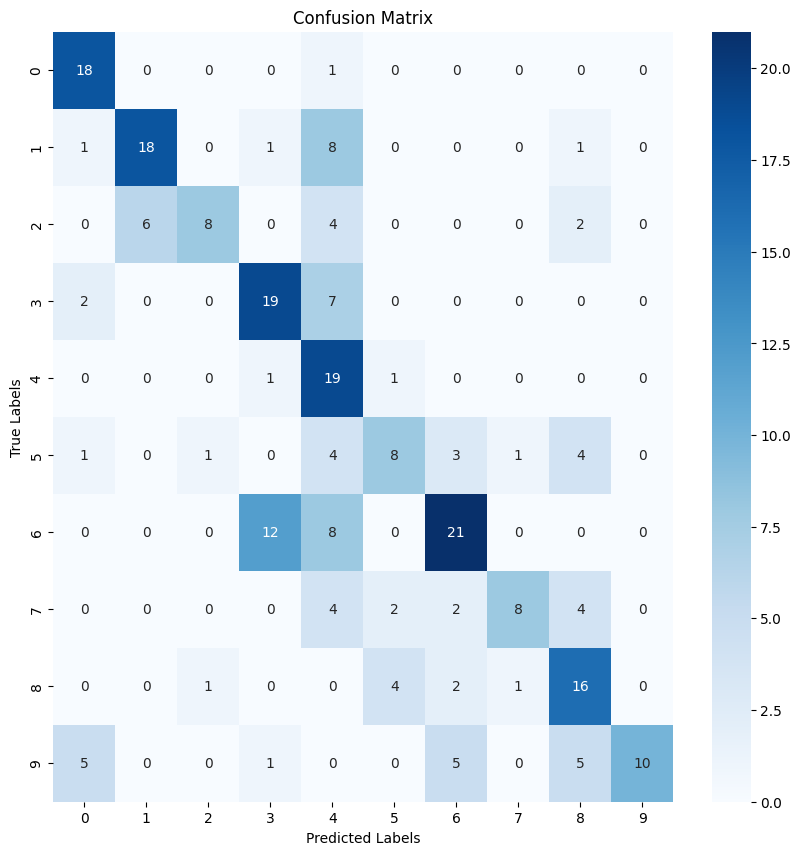

Accuracy: 0.58
F1-score: 0.62
0.33643617021276595
0.58
---------------------------------------
tensor(1.3863, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9878, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.2989, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9540, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0204, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.1167, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8912, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9873, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.2848, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.1057, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8124, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.7183, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8357, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0485, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8539, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9661, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.

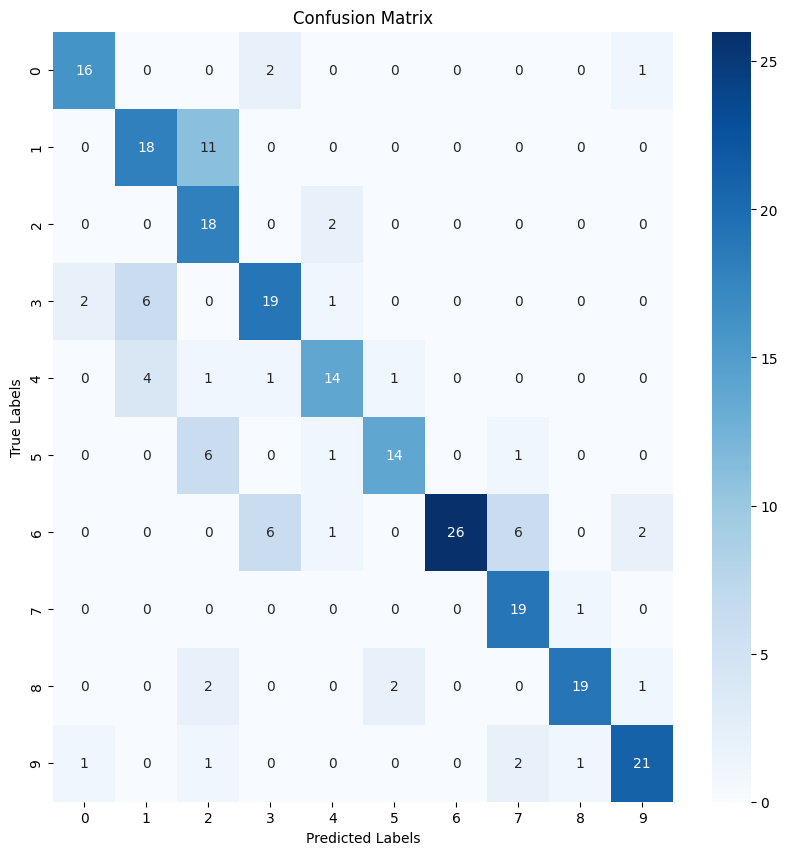

Accuracy: 0.74
F1-score: 0.76
0.6914893617021277
0.736
---------------------------------------
tensor(0.4798, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4141, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3961, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4182, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3874, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.1981, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3729, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4528, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6200, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4650, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5050, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4210, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3552, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3317, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.2795, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6756, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.

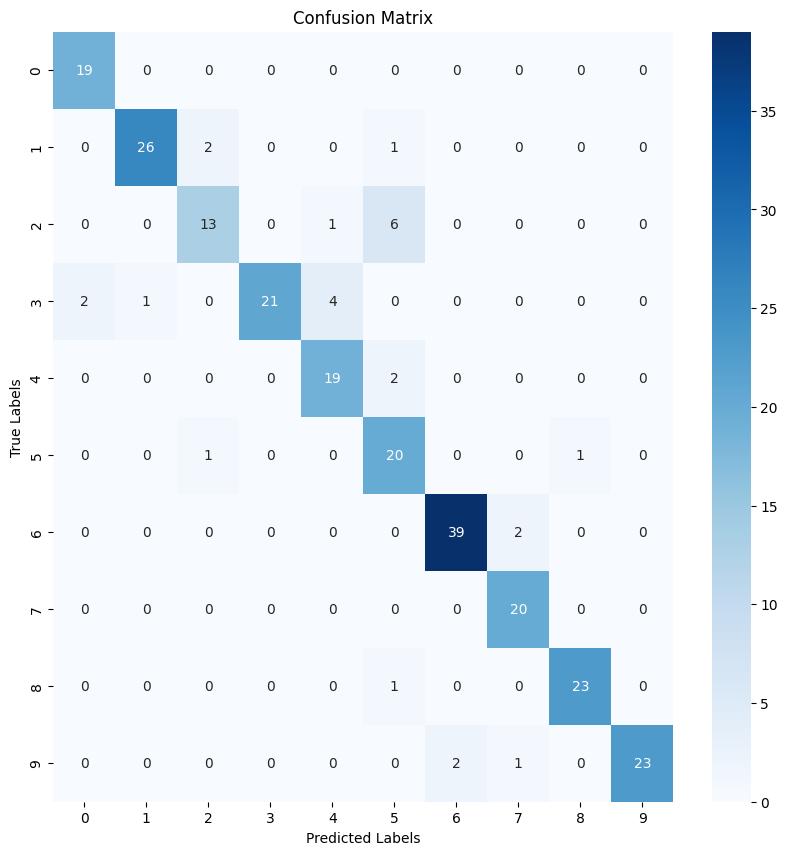

Accuracy: 0.89
F1-score: 0.89
0.8617021276595744
0.892
---------------------------------------
tensor(0.2070, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.1178, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.2896, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.2531, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.0757, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.0727, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3312, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.2371, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4360, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.1231, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.2070, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3593, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.2658, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.0659, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4425, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.1691, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.

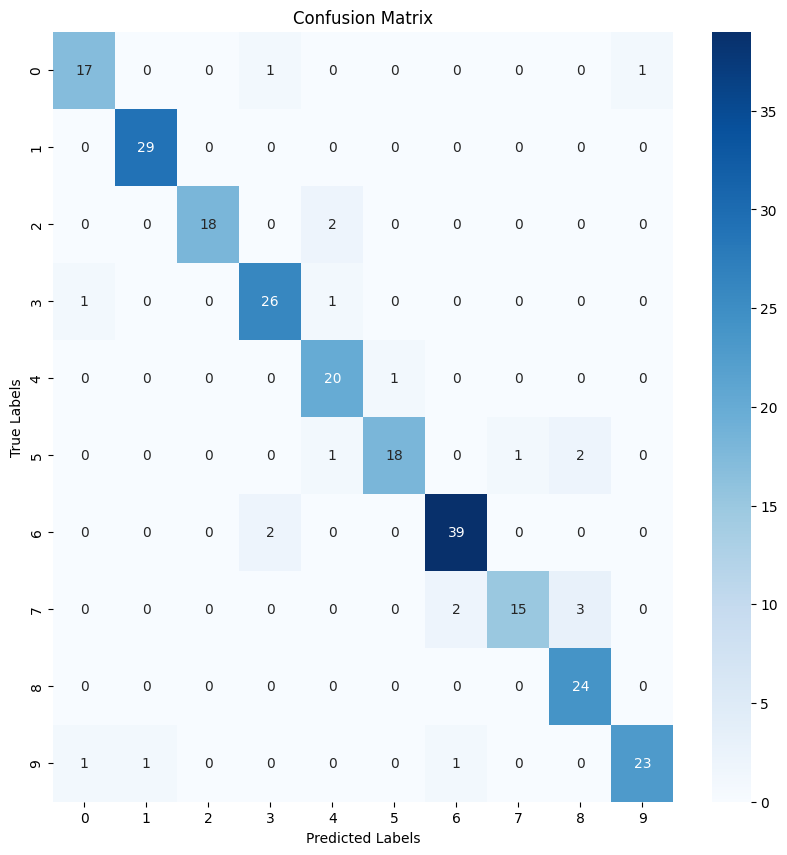

Accuracy: 0.92
F1-score: 0.91
0.9268617021276596
0.916
---------------------------------------
tensor(0.0729, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.0854, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.1190, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.1048, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.1664, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.2083, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.0548, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.0729, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.0764, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.2911, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.1181, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.0835, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.2143, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.0261, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5460, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.1702, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.

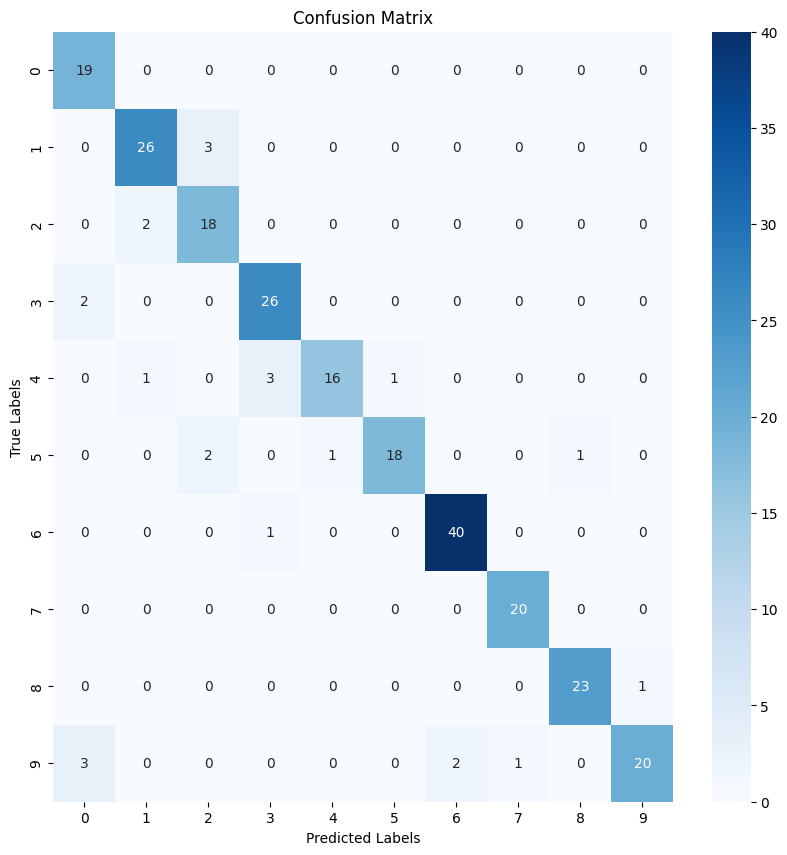

Accuracy: 0.90
F1-score: 0.90
0.9601063829787234
0.904
---------------------------------------


In [18]:
acc_list = []
f1_list = []
loss_list = []

# loop over our epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0

  # loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		x = x.to(dtype=torch.float32)
		y = y.to(dtype=torch.float32)
		#print(x.shape)
		#print(x,y)
		x = x.to(device)
		y = y.to(device)
		#(x, y) = (x.to(device), y.to(device))

		# perform a forward pass and calculate the training loss
		opt.zero_grad()
		pred = model(x)

		loss = lossFn(pred, y)
		print(loss)
		loss_list.append(loss.cpu())
		# zero out the gradients, perform the backpropagation step, and update the weights
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

  # switch off autograd for evaluation
	all_preds = []
	all_targets = []

	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			x = x.to(dtype=torch.float32)
			y = y.to(dtype=torch.float32)
	 		# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			output = model(x)
			totalValLoss += lossFn(output, y)
			# calculate the number of correct predictions
			valCorrect += (output.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

			preds = (output.argmax(1)).type(torch.int)
			#preds = np.argmax(preds, axis=1)
			targets = (y.argmax(1)).type(torch.int)
			#print(preds)
			#print(targets)
			all_preds.extend(preds.cpu())
			all_targets.extend(targets.cpu())

	all_preds = np.array(all_preds)
	all_targets = np.array(all_targets)
	conf_mat = confusion_matrix(all_targets, all_preds)
	print(f'Epoch {e + 1}, Confusion Matrix:')
	print(conf_mat)

	plt.figure(figsize=(10, 10))
	sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], yticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
	plt.xlabel('Predicted Labels')
	plt.ylabel('True Labels')
	plt.title('Confusion Matrix')
	plt.show()

	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)

	# Calculate accuracy
	accuracy = np.trace(conf_mat) / np.sum(conf_mat)
	acc_list.append(accuracy)

	# Calculate precision and recall
	true_positives = np.diag(conf_mat)
	false_positives = np.sum(conf_mat, axis=0) - true_positives
	false_negatives = np.sum(conf_mat, axis=1) - true_positives

	precision = np.mean(true_positives / (true_positives + false_positives))
	recall = np.mean(true_positives / (true_positives + false_negatives))

	# Calculate F1-score
	f1_score = 2 * (precision * recall) / (precision + recall)
	f1_list.append(f1_score)

	print(f"Accuracy: {accuracy:.2f}")
	print(f"F1-score: {f1_score:.2f}")

	print(trainCorrect)
	print(valCorrect)
	print('---------------------------------------')

	torch.save(model.state_dict(), f'weights_vgg_change_{e}.pt')


In [19]:
print(loss_list)

[tensor(2.3362, grad_fn=<ToCopyBackward0>), tensor(2.3063, grad_fn=<ToCopyBackward0>), tensor(2.3436, grad_fn=<ToCopyBackward0>), tensor(2.2640, grad_fn=<ToCopyBackward0>), tensor(2.2942, grad_fn=<ToCopyBackward0>), tensor(2.2074, grad_fn=<ToCopyBackward0>), tensor(2.1797, grad_fn=<ToCopyBackward0>), tensor(2.0967, grad_fn=<ToCopyBackward0>), tensor(2.1809, grad_fn=<ToCopyBackward0>), tensor(2.0321, grad_fn=<ToCopyBackward0>), tensor(1.8177, grad_fn=<ToCopyBackward0>), tensor(1.6570, grad_fn=<ToCopyBackward0>), tensor(1.6287, grad_fn=<ToCopyBackward0>), tensor(1.9572, grad_fn=<ToCopyBackward0>), tensor(1.5079, grad_fn=<ToCopyBackward0>), tensor(1.8293, grad_fn=<ToCopyBackward0>), tensor(1.3952, grad_fn=<ToCopyBackward0>), tensor(1.8796, grad_fn=<ToCopyBackward0>), tensor(1.5463, grad_fn=<ToCopyBackward0>), tensor(1.4865, grad_fn=<ToCopyBackward0>), tensor(1.4886, grad_fn=<ToCopyBackward0>), tensor(1.1401, grad_fn=<ToCopyBackward0>), tensor(1.5586, grad_fn=<ToCopyBackward0>), tensor(1.7

In [20]:
print(acc_list)

[0.58, 0.736, 0.892, 0.916, 0.904]


In [21]:
print(f1_list)

[0.6214237583901676, 0.7568123498330789, 0.8911119698998589, 0.913484011365917, 0.9024918806548728]


In [28]:
loss_vals = []
for i in loss_list:
  loss = i.item()
  #print(loss)
  loss_vals.append(loss)

print(loss_vals)

[2.336223602294922, 2.3063347339630127, 2.343611717224121, 2.2640256881713867, 2.2941734790802, 2.207437515258789, 2.179739475250244, 2.0967471599578857, 2.1809329986572266, 2.0320823192596436, 1.8177307844161987, 1.657046914100647, 1.628741979598999, 1.9572489261627197, 1.5078856945037842, 1.8292746543884277, 1.395183801651001, 1.8796329498291016, 1.5463190078735352, 1.4865021705627441, 1.4885681867599487, 1.1401381492614746, 1.5586360692977905, 1.7625107765197754, 1.3862519264221191, 0.9878215193748474, 1.2988921403884888, 0.9539810419082642, 1.0204062461853027, 1.1166707277297974, 0.8912461996078491, 0.9873242974281311, 1.2847814559936523, 1.105688452720642, 0.812362551689148, 0.718259334564209, 0.8357455730438232, 1.0484561920166016, 0.8538793325424194, 0.9661333560943604, 0.845643937587738, 0.4410124719142914, 0.7707318663597107, 0.9611276984214783, 0.6040025949478149, 0.5105887651443481, 0.798820972442627, 0.7175159454345703, 0.47977256774902344, 0.41411352157592773, 0.3961354494

In [32]:
loss_vals.sort(reverse=True)

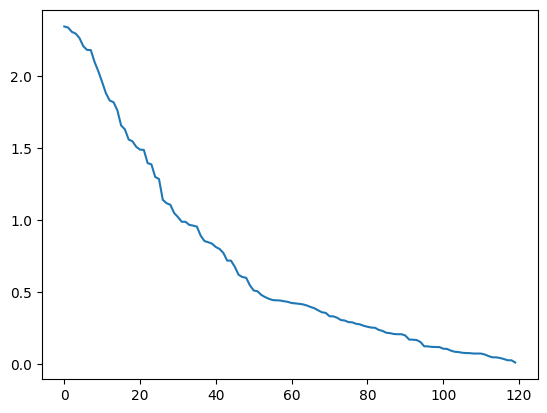

In [33]:
plt.plot(loss_vals)